# Attack Consistency

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import os
import torch
import numpy as np
import pickle
from typing import List, Tuple, Dict

import sys
sys.path.append("../../../")
sys.path.append("../../")
sys.path.append("../")
from miae.eval_methods.experiment import ExperimentSet, TargetDataset
from experiment.mia_comp.datasets import CINIC10

COLUMNWIDTH = 241.14749
COLUMNWIDTH_INCH = 0.01384 * COLUMNWIDTH
TEXTWIDTH = 506.295
TEXTWIDTH_INCH = 0.01384 * TEXTWIDTH

sns.set_context("paper")

# set fontsize
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=7)
plt.rc('font', size=7)       
plt.rc('axes', titlesize=8)    
plt.rc('axes', labelsize=8)

# modify this to set up directory:
DATA_DIR = "data"

mia_name_mapping = {"losstraj": "losstraj", "shokri": "Class-NN", "yeom": "LOSS", "lira": "LiRA", "aug": "aug", "calibration": "calibration", "reference": "reference"}
mia_color_mapping = {"losstraj": '#1f77b4', "shokri": '#ff7f0e', "yeom": '#2ca02c', "lira": '#d62728', "aug": '#9467bd', "calibration": '#8c564b', "reference": '#e377c2'}

seeds = [0, 1, 2, 3, 4, 5]
fpr = 0.1
dataset = "cifar10"
model = "resnet56"

sns.set_context("paper")

### Here are the factors that we will consider in our ablation study:
- Shadow Model Different Initialization: 
- Number of Shadow Models
- Attack Model

### Standard experiment setup in our paper:
- Number of Shadow Models: 10 for Class-NN attack, 20 for reference attack and LiRA, 1 for difficulty calibration attack, 1 for losstraj, 1 for augmentation attack
- Shadow Model Different Initialization: True
- Attack Model: for attacks that uses attack model, we train attack model with seeds according to the attack seed, and this seed would contribute to the data shuffling and batching in the attack model optimization.

We will call this set as *standard*.

### Here are the settings that we will consider in our ablation study:
- *same_shadow_diff_attack*: for the the same attack model, we fix the shadow model used, and try train 6 different attack models based on it to see how much the randomness in attack model contributes to the variance of MIA predictions. For this experiment, we only consider the Class-NN attack, augmentation attack, Loss trajectory attack. We will compare this set to *standard*. To execute this experiment, we save the shadow model each attack at seed=0, and then train the attack model with different seeds.

- *shadow_init*: study the effect of shadow model initialization. We will compare the results of the same attack model trained on different shadow models with different initialization. We will compare this set to *standard*.

- *diff_number_shadow*: study the effect of number of shadow models. We will compare the results of the same attack model trained on different number of shadow models. We will compare this set to *standard*.
  
- *diff_data_arch*: study the similarity of different models. We want to observe a large disparity throughout different dataset and architecture. We will have a scatter plot to show the similarity of different attacks performance throughout different dataset and architecture


In [17]:
# Specify the experiment

exps = ["same_shadow_diff_attack", 
        "shadow_init", 
        "diff_number_shadow", 
        "diff_data_arch", 
        "lira_online_vs_offline", 
        "canaries"]
# exp = exps[0:4] # select the experiment
exp = exps[5]

Here, we define general code that's used to compare the agreement of prediction between attack's instances. We compute the agreement of predictions between sets. 

Pair-wise Jaccard Similarity (Consistency) of attack $A$'s n predictions:

$$
\text{Consistency(A)} = \frac{1}{\binom{n}{2}} \sum_{i < j}  J(A_i, A_j)
$$

Where $A_x$ is the x-th instance's prediction set of attack $A$, and $J$ is the Jaccard similarity between two sets.

$$
J(A_i, A_j) = \frac{|A_i \cap A_j|}{|A_i \cup A_j|}
$$

We use the similarity as a sense of **Consistency** of attack.

Through the experiments here, we are going to use 6 instances of each attack for the pair-wise Jaccard Similarity computation.

## 1. Same Shadow Model Different Attack Model

In [18]:
if 'same_shadow_diff_attack' in exp:
    attack_list = ["losstraj", "shokri", "aug"]

    output_dir = f"{DATA_DIR}/same_shadow_diff_attack"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # loading dataset and predictions
    target_dataset = TargetDataset.from_dir(dataset, 
    f"{DATA_DIR}/miae_standard_exp/target/{dataset}")

    standard_pred_dir = f"{DATA_DIR}/miae_standard_exp"
    same_shadow_diff_attack_pred_dir = f"{DATA_DIR}/same_shadow_diff_attack"

    standard_exp_set = ExperimentSet.from_dir(target_dataset, attack_list, standard_pred_dir, seeds, model, fpr)
    same_shadow_diff_attack_exp_set = ExperimentSet.from_dir(target_dataset, attack_list, same_shadow_diff_attack_pred_dir, seeds, model, fpr)

    # get jaccard similarity
    df_non_can = pd.DataFrame(columns=["same_shadow_models", "attack", "full_name", "jaccard_sim"]).astype({
        "jaccard_sim": float, "same_shadow_models": bool, "attack": str, "full_name": str})

    for attack in attack_list:
        jaccard_sim_standard = standard_exp_set.attack_pair_wise_jaccard_similarity(attack)
        jaccard_sim_same_shadow_diff_attack = same_shadow_diff_attack_exp_set.attack_pair_wise_jaccard_similarity(attack)

        df_non_can = pd.concat([df_non_can, pd.DataFrame([{"same_shadow_models": False, "attack": attack, "jaccard_sim": 
                jaccard_sim_standard, "full_name": mia_name_mapping[attack]},
                {"same_shadow_models": True, "attack": attack, "jaccard_sim":
                jaccard_sim_same_shadow_diff_attack, "full_name": mia_name_mapping[attack]}])], ignore_index=True)
    df_non_can.to_csv(f"{output_dir}/same_shadow_diff_attack_jaccard_sim.csv", index=False)

    # plot jaccard similarity
    sns.set_context("paper", font_scale=1.5)
    fig, ax = plt.subplots()
    sns.barplot(x="full_name", y="jaccard_sim", hue="same_shadow_models", data=df_non_can, ax=ax)
    plt.xlabel("Attack", fontweight='bold')
    plt.ylabel("Consistency", fontweight='bold')
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{x:.1f}' for x in np.arange(0, 1.1, 0.1)])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')

    ax.legend(title="same attack training set", loc="upper right")
    
    
    plt.savefig(f"{output_dir}/same_shadow_diff_attack_jaccard_sim.pdf", bbox_inches='tight', format='pdf')
    print("jaccard similarity plot saved at ", f"{output_dir}/same_shadow_diff_attack_jaccard_sim.pdf")

    
        

## 2. shadow model initialization

In [19]:
if 'shadow_init' in exp:
    attack_list = ["losstraj", "shokri", "lira", "aug", "calibration", "reference"]

    output_dir = f"{DATA_DIR}/diff_shadow_init_experiment"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # loading dataset and predictions
    target_dataset = TargetDataset.from_dir(dataset, 
    f"{DATA_DIR}/miae_standard_exp/target/{dataset}")

    diff_shadow_init_pred_dir = f"{DATA_DIR}/miae_standard_exp"

    diff_shadow_init_exp_set = ExperimentSet.from_dir(target_dataset, attack_list, diff_shadow_init_pred_dir,
                                                      seeds, model, fpr)
    
    same_shadow_init_pred_dir = f"{DATA_DIR}/miae_standard_exp_fix_shadow_init"

    same_shadow_init_exp_set = ExperimentSet.from_dir(target_dataset, attack_list, same_shadow_init_pred_dir,
                                                        seeds, model, fpr)

    # get jaccard similarity
    df_non_can = pd.DataFrame(columns=["shadow_model_diff_init", "attack", "full_name", "jaccard_sim"]).astype({
        "jaccard_sim": float, "shadow_model_diff_init": bool, "attack": str, "full_name": str})

    for attack in attack_list:
        jaccard_sim_diff_shadow_init = diff_shadow_init_exp_set.attack_pair_wise_jaccard_similarity(attack)
        jaccard_sim_same_shadow_init = same_shadow_init_exp_set.attack_pair_wise_jaccard_similarity(attack)

        df_non_can = pd.concat([df_non_can, pd.DataFrame([{"shadow_model_diff_init": True, "attack": attack, "jaccard_sim": 
                jaccard_sim_diff_shadow_init, "full_name": mia_name_mapping[attack]},
                {"shadow_model_diff_init": False, "attack": attack, "jaccard_sim":
                jaccard_sim_same_shadow_init, "full_name": mia_name_mapping[attack]}])], ignore_index=True)
    df_non_can.to_csv(f"{output_dir}/shadow_init_jaccard_sim.csv", index=False)

    # plot jaccard similarity
    sns.set_context("paper", font_scale=1.5)
    fig, ax = plt.subplots()
    sns.barplot(x="full_name", y="jaccard_sim", hue="shadow_model_diff_init", data=df_non_can, ax=ax)
    plt.xlabel("Attack", fontweight='bold')
    plt.ylabel("Consistency", fontweight='bold')
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{x:.1f}' for x in np.arange(0, 1.1, 0.1)])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')

    ax.legend(title="different initial weights", loc="upper right")
    
    plt.savefig(f"{output_dir}/shadow_init_jaccard_sim.pdf", bbox_inches='tight', format='pdf')
    print("jaccard similarity plot saved at ", f"{output_dir}/shadow_init_jaccard_sim.pdf")
    


## 3. different number of shadow models

To display the change of consistency of an attack while varying the number of shadow models, we will plot the similarity of the attack's predictions for each number of shadow models.

In [20]:
def get_consistency_trajectory(exp_set: ExperimentSet, attack: str, shadow_num_shadow_models: List[int]
                               ) -> List[float]:
    trajectory = []
    # build attack names
    attacks = [attack + str(i) for i in shadow_num_shadow_models]

    for attack in attacks:
        consistency = exp_set.attack_pair_wise_jaccard_similarity(attack)
        trajectory.append(consistency)

    return trajectory


if "diff_number_shadow" in exp:
    lira_shadow_num_shadow_models = [20, 40, 60, 80, 100]
    calibration_shadow_num_shadow_models = [1, 3, 5, 7, 9, 11, 13]
    output_dir = f"{DATA_DIR}/diff_number_shadow_models"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # note: both datasets are the same
    target_dataset = TargetDataset.from_dir(dataset, 
    f"{DATA_DIR}/calibration_loss_diff_num_shadow/target/{dataset}")


    # for calibration
    calibration_names = [f"calibration{i}" for i in calibration_shadow_num_shadow_models]
    calibration_exp_set = ExperimentSet.from_dir(target_dataset, calibration_names, f"{DATA_DIR}/calibration_loss_diff_num_shadow", seeds, model, fpr)
    calibration_trajectory = get_consistency_trajectory(calibration_exp_set, "calibration", calibration_shadow_num_shadow_models)

    # plot
    sns.set_context("paper")
    plt.rcParams["font.weight"] = "bold"
    fig, ax = plt.subplots(figsize=(COLUMNWIDTH_INCH, COLUMNWIDTH_INCH / 1.618))

    sns.lineplot(x=calibration_shadow_num_shadow_models, y=calibration_trajectory, ax=ax,
                 markers=True, marker="o", label="calibration", color=mia_color_mapping["calibration"])
    plt.xlabel("Number of shadow models", fontweight='bold')
    plt.ylabel("Consistency", fontweight='bold')
    plt.xticks(np.arange(1, 14, 2))
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{x:.1f}' for x in np.arange(0, 1.1, 0.1)])
    plt.tight_layout()

    plt.savefig(f"{output_dir}/calibration_diff_shadow_model.pdf", bbox_inches='tight', format='pdf')
    print("calibration plot saved at ", f"{output_dir}/calibration_diff_shadow_model.pdf")

    # for lira and reference
    lira_names = [f"lira{i}" for i in lira_shadow_num_shadow_models]
    lira_exp_set = ExperimentSet.from_dir(target_dataset, lira_names, f"{DATA_DIR}/lira_diff_num_shadow", seeds, model, fpr)
    lira_trajectory = get_consistency_trajectory(lira_exp_set, "lira", lira_shadow_num_shadow_models)
    reference_names = [f"reference{i}" for i in lira_shadow_num_shadow_models]
    reference_exp_set = ExperimentSet.from_dir(target_dataset, reference_names, f"{DATA_DIR}/lira_diff_num_shadow", seeds, model, fpr)
    reference_trajectory = get_consistency_trajectory(reference_exp_set, "reference", lira_shadow_num_shadow_models)

    # plot
    sns.set_context("paper")
    plt.rcParams["font.weight"] = "bold"
    fig, ax = plt.subplots(figsize=(COLUMNWIDTH_INCH, COLUMNWIDTH_INCH / 1.618))

    sns.lineplot(x=lira_shadow_num_shadow_models, y=lira_trajectory, ax=ax,
                 markers=True, marker="o", label="lira", color=mia_color_mapping["lira"]
                 )
    sns.lineplot(x=lira_shadow_num_shadow_models, y=reference_trajectory, ax=ax,
                 markers=True, marker="o", label="reference", color=mia_color_mapping["reference"]
                 )
    plt.xlabel("Number of shadow models", fontweight='bold')
    plt.ylabel("Consistency", fontweight='bold')
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{x:.1f}' for x in np.arange(0, 1.1, 0.1)])
    plt.tight_layout()
    

    plt.savefig(f"{output_dir}/lira_diff_shadow_model.pdf", bbox_inches='tight', format='pdf')
    
    

## 4. different data and architecture

In [21]:
if exp == "diff_data_arch":
    attack_list = ["losstraj", "shokri", "lira", "aug", "calibration", "reference", "yeom"]
    models = ["resnet56", "vgg16", "wrn32_4", "mobilenet"]
    datasets = ["cifar10", "cifar100", "cinic10"]

    output_dir = f"{DATA_DIR}/diff_data_arch"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    diff_data_arch_pred_dir = f"{DATA_DIR}/miae_standard_exp"

    df_non_can = pd.DataFrame(columns=["model", "dataset", "attack", "jaccard_sim"]).astype({
        "jaccard_sim": float, "model": str, "attack": str, "dataset": str})

    for dataset in datasets:
        # loading dataset and predictions
        target_dataset = TargetDataset.from_dir(dataset, 
        f"{DATA_DIR}/miae_standard_exp/target/{dataset}")

        for model in models:
            exp_set = ExperimentSet.from_dir(target_dataset, attack_list, diff_data_arch_pred_dir,
                                                            seeds, model, fpr)
        
            # get jaccard similarity
            for attack in attack_list:
                jaccard_sim = exp_set.attack_pair_wise_jaccard_similarity(attack)
                df_non_can = pd.concat([df_non_can, pd.DataFrame([{"model": model, "attack": mia_name_mapping[attack], "jaccard_sim": 
                        jaccard_sim, "dataset": dataset}])], ignore_index=True)


    # save df via pickle
    df_non_can.to_csv(f"{output_dir}/diff_data_arch_jaccard_sim.csv", index=False)
    print("jaccard similarity saved at ", f"{output_dir}/diff_data_arch_jaccard_sim.csv")


In [22]:
if exp == "diff_data_arch":
    for ds in datasets:
        # barplot
        sns.set_context("paper")
        plt.rcParams["font.weight"] = "bold"
        fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCH, TEXTWIDTH_INCH / 1.618))

        sns.barplot(x="attack", y="jaccard_sim", hue="model", data=df_non_can[df_non_can["dataset"] == ds], ax=ax, capsize=.4)
        plt.xlabel("Attak", fontweight='bold')
        plt.ylabel("Consistency", fontweight='bold')
        plt.yticks(np.arange(0, 1.1, 0.1), [f'{x:.1f}' for x in np.arange(0, 1.1, 0.1)])
        ax.set_xticklabels(ax.get_xticklabels())
        ax.legend(title="model", loc="upper right")
        plt.tight_layout()
        plt.savefig(f"{output_dir}/diff_data_arch_jaccard_sim_{ds}.pdf", bbox_inches='tight', format='pdf')
        print("jaccard similarity plot saved at ", f"{output_dir}/diff_data_arch_jaccard_sim_{ds}.pdf")



## 5. LiRA Online vs Offline

Make sure to prepare lira online and offline results before running this code.

In [23]:
if exp == "lira_online_vs_offline":
    from miae.utils.roc_auc import fig_fpr_tpr
    attack_list = ["lira", "lira_offline"]
    models = ["resnet56"]
    datasets = ["cifar10"]

    output_dir = f"{DATA_DIR}/lira_online_vs_offline"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    lira_online_vs_offline_pred_dir = f"{DATA_DIR}/miae_standard_exp"

    # plot ROC comp of these 2 variants
    for dataset in datasets:
        # loading dataset and predictions
        target_dataset = TargetDataset.from_dir(dataset, 
        f"{DATA_DIR}/miae_standard_exp/target/{dataset}")

        for model in models:
            pred = []
            membership_gt = []
            exp_set = ExperimentSet.from_dir(target_dataset, attack_list, lira_online_vs_offline_pred_dir,
                                                            seeds, model, fpr_to_adjust=None)
            for attack in attack_list:
                pred.append(exp_set.retrieve_preds(attack, 0).pred_arr)
                membership_gt.append(exp_set.retrieve_preds(attack, 0).ground_truth_arr)
            print(f"ROC of online vs offline on {dataset} {model}")
            image_out_dir = f"{output_dir}/roc"
            if not os.path.exists(image_out_dir):
                os.makedirs(image_out_dir)
            fig_fpr_tpr(pred, membership_gt, attack_list, f"{image_out_dir}/{dataset}_{model}_roc.pdf")
            print(f"ROC plot saved at {image_out_dir}/{dataset}_{model}_roc.pdf")

            

In [24]:
# Consistency Check
if exp == "lira_online_vs_offline":
    online_vs_offline_name_mapping = {"lira": "online", "lira_offline": "offline"}
    attack_list = ["lira", "lira_offline"]
    models = ["resnet56", "vgg16", "wrn32_4", "mobilenet"]
    datasets = ["cifar10"]
    for dataset in datasets:
        # loading dataset and predictions
        target_dataset = TargetDataset.from_dir(dataset, 
        f"{DATA_DIR}/miae_standard_exp/target/{dataset}")

        df_non_can = pd.DataFrame(columns=["model", "attack", "jaccard_sim"]).astype({
            "jaccard_sim": float, "model": str, "attack": str})

        for model in models:
            pred = []
            membership_gt = []
            exp_set = ExperimentSet.from_dir(target_dataset, attack_list, lira_online_vs_offline_pred_dir,
                                                            seeds, model, fpr_to_adjust=0.1)
            # get jaccard similarity
            for attack in attack_list:
                jaccard_sim = exp_set.attack_pair_wise_jaccard_similarity(attack)
                df_non_can = pd.concat([df_non_can, pd.DataFrame([{"model": model, "attack": online_vs_offline_name_mapping[attack], "jaccard_sim": 
                        jaccard_sim}])], ignore_index=True)
        # save df via pickle
        df_non_can.to_csv(f"{output_dir}/lira_online_vs_offline_jaccard_sim_{dataset}.csv", index=False)
        print("jaccard similarity saved at ", f"{output_dir}/lira_online_vs_offline_jaccard_sim_{dataset}.csv")

        # barplot
        sns.set_context("paper")
        plt.rcParams["font.weight"] = "bold"
        fig, ax = plt.subplots(figsize=(COLUMNWIDTH_INCH, COLUMNWIDTH_INCH))

        sns.barplot(x="attack", y="jaccard_sim", hue="model", data=df_non_can, ax=ax, capsize=.4)
        plt.xlabel("Attak", fontweight='bold')
        plt.ylabel("Consistency", fontweight='bold')
        plt.yticks(np.arange(0, 1.1, 0.1), [f'{x:.1f}' for x in np.arange(0, 1.1, 0.1)])
        ax.set_xticklabels(ax.get_xticklabels())
        ax.legend(title="model", loc="upper right")
        plt.tight_layout()
        plt.savefig(f"{output_dir}/lira_online_vs_offline_jaccard_sim_{dataset}.pdf", bbox_inches='tight', format='pdf')
        print("jaccard similarity plot saved at ", f"{output_dir}/lira_online_vs_offline_jaccard_sim_{dataset}.pdf")

        # print average consistency of each attack variant
        print(f"average consistency of each attack variant on {dataset}")
        print(df_non_can.groupby("attack").mean())
        


## 6. Consistency on canaries members

In [25]:
def from_can_to_non_canary_indices(canary_indices: np.ndarray, dataset) -> np.ndarray:
    """
    canary_indices is a array of indices of canaries, 
    and we want to flip the indices to get non_canary_indices
    """
    if "cifar10" in dataset or "cifar100" in dataset or "cinic10" in dataset:
        member_length = 15000
    else:
        raise ValueError("dataset not supported yet")

    non_canary_indices = []
    for i in range(member_length):
        if i not in canary_indices:
            non_canary_indices.append(i)

    return np.array(non_canary_indices)

if exp == "canaries":
    attack_list = ["losstraj", "shokri", "lira", "aug", "calibration", "reference"]
    # attack_list = ["losstraj", "shokri", "calibration"]
    # models = ["resnet56", "vgg16", "wrn32_4", "mobilenet"]
    models = ["resnet56"]
    # datasets = ["cifar10", "cifar100", "cinic10"]
    datasets = ["cifar10_canaries_300"]

    output_dir = f"{DATA_DIR}/consistency_on_canaries"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    diff_data_arch_pred_dir = f"{DATA_DIR}/miae_standard_exp_canary"

    df_can = pd.DataFrame(columns=["model", "dataset", "attack", "jaccard_sim"]).astype({
        "jaccard_sim": float, "model": str, "attack": str, "dataset": str})
    df_non_can = pd.DataFrame(columns=["model", "dataset", "attack", "jaccard_sim"]).astype({
        "jaccard_sim": float, "model": str, "attack": str, "dataset": str})

    for dataset in datasets:
        # loading dataset and predictions
        target_dataset = TargetDataset.from_dir(dataset, 
        f"{DATA_DIR}/miae_standard_exp_canary/target/{dataset}")

        canary_indices = np.load(f"{DATA_DIR}/miae_standard_exp_canary/target/{dataset}/canary_indices.npy")
        # flip canary_indices to get non_canary_indices
        non_canary_indices = from_can_to_non_canary_indices(canary_indices, dataset=dataset)

        for model in models:
            exp_set = ExperimentSet.from_dir(target_dataset, attack_list, diff_data_arch_pred_dir,
                                                            seeds, model, fpr)
        
            # get jaccard similarity
            for attack in attack_list:
                jaccard_sim_non_can = exp_set.attack_pair_wise_jaccard_similarity(attack, canary_indices=non_canary_indices)
                jaccard_sim_can = exp_set.attack_pair_wise_jaccard_similarity(attack, canary_indices=canary_indices)

                df_non_can = pd.concat([df_non_can, pd.DataFrame([{"model": model, "attack": mia_name_mapping[attack], "jaccard_sim":
                        jaccard_sim_non_can, "dataset": dataset}])], ignore_index=True)

                df_can = pd.concat([df_can, pd.DataFrame([{"model": model, "attack": mia_name_mapping[attack], "jaccard_sim": 
                        jaccard_sim_can, "dataset": dataset}])], ignore_index=True)


    # save df via pickle
    df_can.to_csv(f"{output_dir}/diff_data_arch_jaccard_sim_canary_only.csv", index=False)
    print("jaccard similarity saved at ", f"{output_dir}/diff_data_arch_jaccard_sim_canary_only.csv")

    df_non_can.to_csv(f"{output_dir}/diff_data_arch_jaccard_sim.csv", index=False)
    print("jaccard similarity saved at ", f"{output_dir}/diff_data_arch_jaccard_sim.csv")

    


/home/wangz56/MIAE/experiment/mia_comp/../../miae/eval_methods/prediction.py:240: RuntimeWarning: invalid value encountered in scalar divide
  return intersection / union


jaccard similarity saved at  /home/data/wangz56/consistency_on_canaries/diff_data_arch_jaccard_sim_canary_only.csv
jaccard similarity saved at  /home/data/wangz56/consistency_on_canaries/diff_data_arch_jaccard_sim.csv


jaccard similarity plot saved at  /home/data/wangz56/consistency_on_canaries/consistency_with_canaries_cifar10_canaries_300.pdf


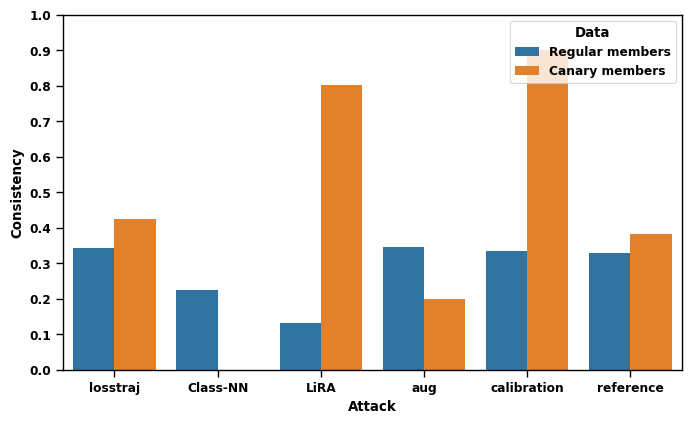

In [26]:
if exp == "canaries":
    # Add a column to indicate the source for color mapping
    df_orig = df_non_can.copy()
    df_orig["source"] = "regular"
    df_can_copy = df_can.copy()
    df_can_copy["source"] = "canary"
    # Combine both dataframes
    df_combined = pd.concat([df_orig, df_can_copy], ignore_index=True)
    
    for ds in datasets:
        sns.set_context("paper")
        plt.rcParams["font.weight"] = "bold"
        fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCH, TEXTWIDTH_INCH / 1.618))
        
        palette = {"regular": "#1f77b4", "canary": "#ff7f0e"}
        data = df_combined[df_combined["dataset"] == ds]
        # Specify hue_order to ensure the legend ordering
        sns.barplot(x="attack", y="jaccard_sim", hue="source", data=data, 
                    ax=ax, palette=palette, capsize=0.4, hue_order=["regular", "canary"])
        
        plt.xlabel("Attack", fontweight="bold")
        plt.ylabel("Consistency", fontweight="bold")
        plt.yticks(np.arange(0, 1.1, 0.1), [f"{x:.1f}" for x in np.arange(0, 1.1, 0.1)])
        ax.set_xticklabels(ax.get_xticklabels())
        
        # Retrieve current legend handles and reassign new labels
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, ["Regular members", "Canary members"], title="Data", loc="upper right")
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/consistency_with_canaries_{ds}.pdf", 
                    bbox_inches="tight", format="pdf")
        print("jaccard similarity plot saved at ", f"{output_dir}/consistency_with_canaries_{ds}.pdf")

ROC of canaries on cifar10_canaries_300 resnet56
Attack: losstraj             AUC: 0.6198   max Accuracy: 0.5862   TPR@0.1%FPR: 0.0000  
Attack: shokri               AUC: 0.5696   max Accuracy: 0.5627   TPR@0.1%FPR: 0.0011  
Attack: lira                 AUC: 0.5678   max Accuracy: 0.5553   TPR@0.1%FPR: 0.0097  
Attack: aug                  AUC: 0.5676   max Accuracy: 0.5524   TPR@0.1%FPR: 0.0006  
Attack: calibration          AUC: 0.6120   max Accuracy: 0.5780   TPR@0.1%FPR: 0.0115  
Attack: reference            AUC: 0.5929   max Accuracy: 0.5883   TPR@0.1%FPR: 0.0055  


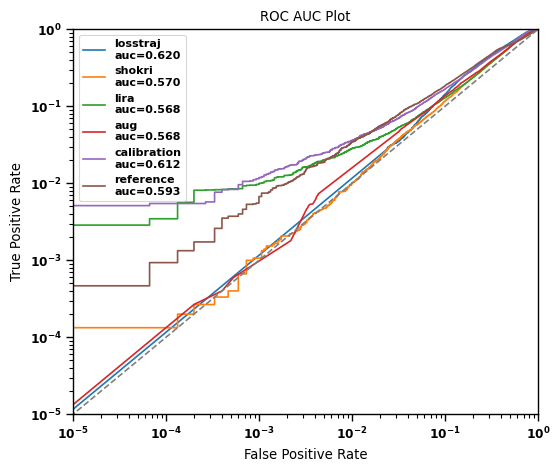

ROC plot saved at /home/data/wangz56/consistency_on_canaries/roc/cifar10_canaries_300_resnet56_roc.pdf


In [27]:
# ROC of those canaries
if exp == "canaries":
    from miae.utils.roc_auc import fig_fpr_tpr
    for dataset in datasets:
        # loading dataset and predictions
        target_dataset = TargetDataset.from_dir(dataset, 
        f"{DATA_DIR}/miae_standard_exp_canary/target/{dataset}")

        df_non_can = pd.DataFrame(columns=["model", "attack", "fpr", "tpr"]).astype({
            "model": str, "attack": str, "fpr": float, "tpr": float})

        canary_indices = np.load(f"{DATA_DIR}/miae_standard_exp_canary/target/{dataset}/canary_indices.npy")

        for model in models:
            pred = []
            membership_gt = []
            exp_set = ExperimentSet.from_dir(target_dataset, attack_list, diff_data_arch_pred_dir,
                                                            seeds, model, fpr_to_adjust=None)
            for attack in attack_list:
                pred.append(exp_set.retrieve_preds(attack, 0).pred_arr)
                membership_gt.append(exp_set.retrieve_preds(attack, 0).ground_truth_arr)
            print(f"ROC of canaries on {dataset} {model}")
            image_out_dir = f"{output_dir}/roc"
            if not os.path.exists(image_out_dir):
                os.makedirs(image_out_dir)
            fig_fpr_tpr(pred, membership_gt, attack_list, f"{image_out_dir}/{dataset}_{model}_roc.pdf")
            print(f"ROC plot saved at {image_out_dir}/{dataset}_{model}_roc.pdf")

            

Jaccard similarity heatmap saved at /home/data/wangz56/consistency_on_canaries/jaccard_similarity_heatmap_coverage_cifar10_canaries_300_resnet56_can.pdf


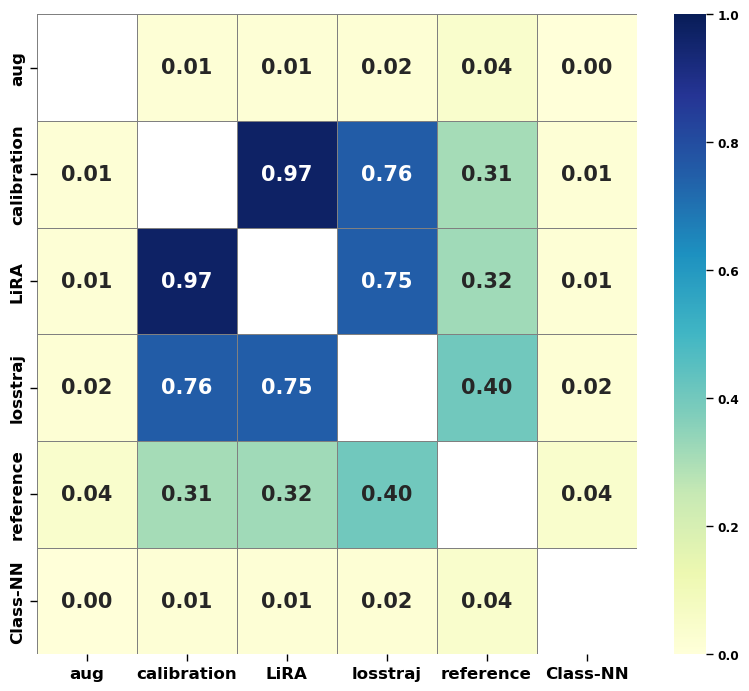

Jaccard similarity heatmap saved at /home/data/wangz56/consistency_on_canaries/jaccard_similarity_heatmap_coverage_cifar10_canaries_300_resnet56_non_can.pdf


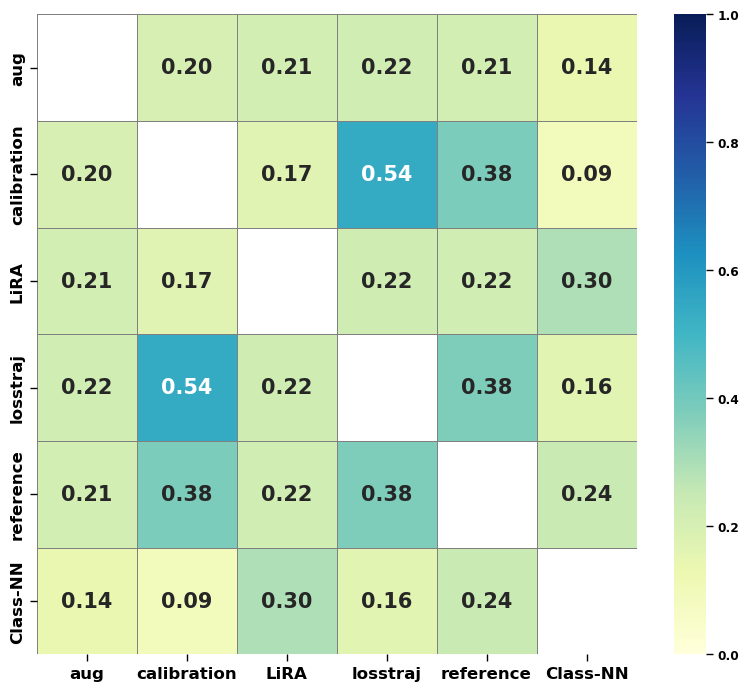

Jaccard similarity heatmap saved at /home/data/wangz56/consistency_on_canaries/jaccard_similarity_heatmap_stability_cifar10_canaries_300_resnet56_can.pdf


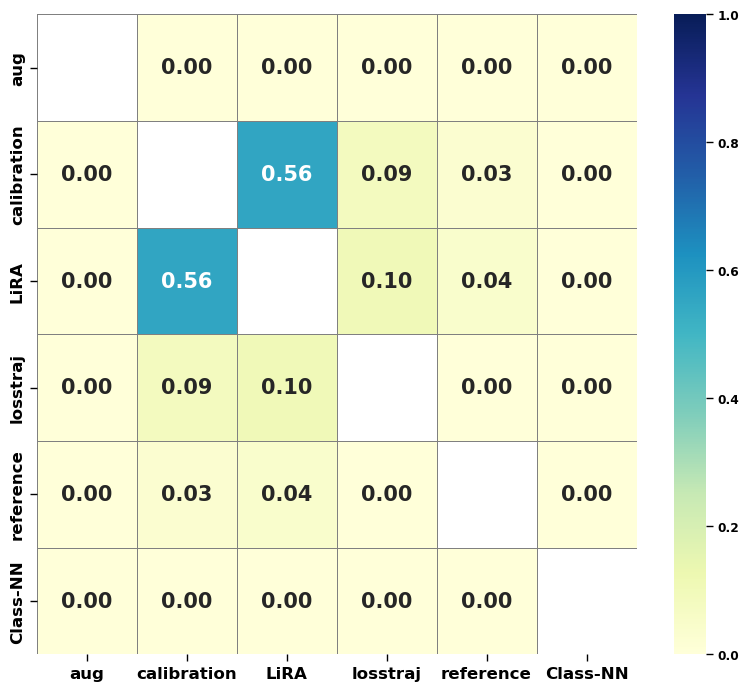

Jaccard similarity heatmap saved at /home/data/wangz56/consistency_on_canaries/jaccard_similarity_heatmap_stability_cifar10_canaries_300_resnet56_non_can.pdf


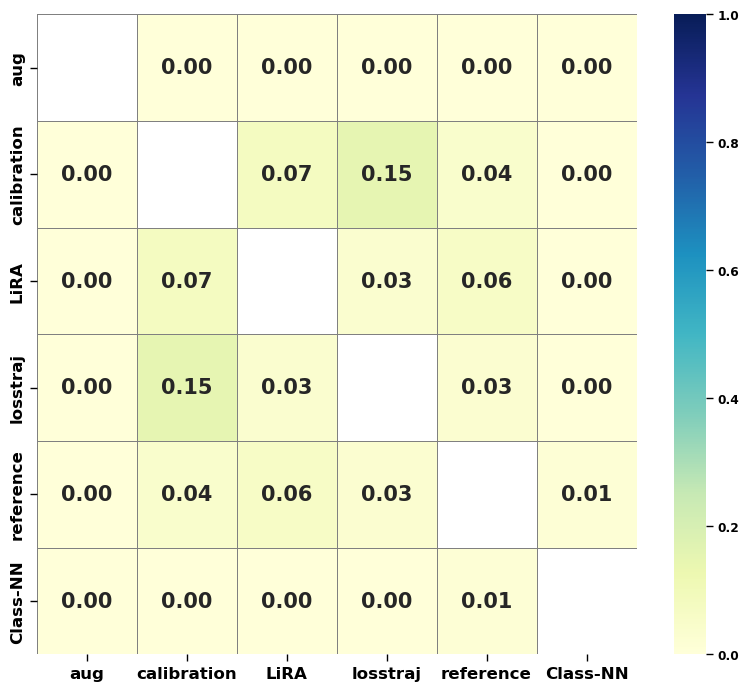

Set size plot saved at /home/data/wangz56/consistency_on_canaries/set_size_cifar10_canaries_300_resnet56_can.pdf


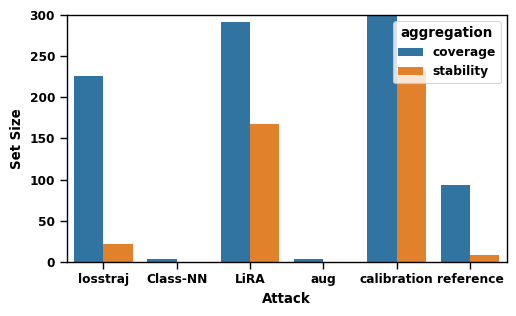

Set size plot saved at /home/data/wangz56/consistency_on_canaries/set_size_cifar10_canaries_300_resnet56_non_can.pdf


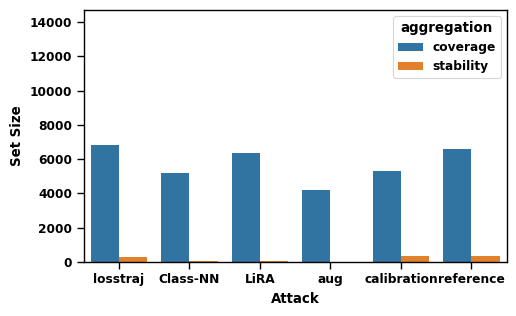

In [34]:
# pairwise jaccard similarity pairs of attacks, when the target dataset is canaries vs non-canaries
def get_pair_jaccard_sim(pred_1, pred_2, canary_indices):
    # convert pred_1 and pred_2 to int 
    pred_1 = np.array(pred_1).astype(int)
    pred_2 = np.array(pred_2).astype(int)
    pred_1 = pred_1[canary_indices]
    pred_2 = pred_2[canary_indices]
    intersection = np.logical_and(pred_1, pred_2)
    union = np.logical_or(pred_1, pred_2)
    if np.sum(union) == 0:
        return 0.0
    jaccard_sim = np.sum(intersection) / np.sum(union)
    return jaccard_sim

def get_attack_pairs(attack_list: List[str]) -> List[Tuple[str, str]]:
    attack_pairs = []
    for i in range(len(attack_list)):
        for j in range(i, len(attack_list)):
            attack_pairs.append((attack_list[i], attack_list[j]))
    return attack_pairs
if exp == "canaries":
    attack_list = ["losstraj", "shokri", "lira", "aug", "calibration", "reference"]
    attack_pairs = get_attack_pairs(attack_list)
    models = ["resnet56"]
    datasets = ["cifar10_canaries_300"]

    output_dir = f"{DATA_DIR}/consistency_on_canaries"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    diff_data_arch_pred_dir = f"{DATA_DIR}/miae_standard_exp_canary"

    df_can = pd.DataFrame(columns=["model", "dataset", "attack_a", "attack_b", "jaccard_sim", "agg"]).astype({
        "jaccard_sim": float, "model": str, "attack_a": str, "attack_b": str, "dataset": str, "agg": str})
    df_non_can = pd.DataFrame(columns=["model", "dataset", "attack_a", "attack_b", "jaccard_sim", "agg"]).astype({
        "jaccard_sim": float, "model": str, "attack_a": str, "attack_b": str, "dataset": str, "agg": str})
    
    df_set_size_can = pd.DataFrame(columns=["model", "dataset", "attack", "set_size", "agg"]).astype({
        "set_size": float, "model": str, "attack": str, "dataset": str, "agg": str})
    df_set_size_non_can = pd.DataFrame(columns=["model", "dataset", "attack", "set_size", "agg"]).astype({
        "set_size": float, "model": str, "attack": str, "dataset": str, "agg": str})
    
    for dataset in datasets:
        # loading dataset and predictions
        target_dataset = TargetDataset.from_dir(dataset, 
        f"{DATA_DIR}/miae_standard_exp_canary/target/{dataset}")

        canary_indices = np.load(f"{DATA_DIR}/miae_standard_exp_canary/target/{dataset}/canary_indices.npy")
        # flip canary_indices to get non_canary_indices
        non_canary_indices = from_can_to_non_canary_indices(canary_indices, dataset=dataset)

        for model in models:
            exp_set = ExperimentSet.from_dir(target_dataset, attack_list, diff_data_arch_pred_dir,
                                                            seeds, model, fpr)
        
            # get jaccard similarity
            for attack_a, attack_b in attack_pairs:
                for can_mask in [canary_indices, non_canary_indices]:
                    # get predictions
                    coverage_a = exp_set.get_preds_coverage(attack_a)
                    coverage_b = exp_set.get_preds_coverage(attack_b)
                    stability_a = exp_set.get_preds_stability(attack_a)
                    stability_b = exp_set.get_preds_stability(attack_b)
                    
                    # record the coverage/stability set size
                    if can_mask is canary_indices:
                        df_set_size_can = pd.concat([df_set_size_can, pd.DataFrame([{"model": model, "attack": attack_a, "set_size":
                                np.sum(coverage_a.pred_arr[can_mask]), "dataset": dataset, "agg": "coverage"}])], ignore_index=True)
                        df_set_size_can = pd.concat([df_set_size_can, pd.DataFrame([{"model": model, "attack": attack_a, "set_size":
                                np.sum(stability_a.pred_arr[can_mask]), "dataset": dataset, "agg": "stability"}])], ignore_index=True)
                    else:
                        df_set_size_non_can = pd.concat([df_set_size_non_can, pd.DataFrame([{"model": model, "attack": attack_a, "set_size":
                                np.sum(coverage_a.pred_arr[can_mask]), "dataset": dataset, "agg": "coverage"}])], ignore_index=True)
                        df_set_size_non_can = pd.concat([df_set_size_non_can, pd.DataFrame([{"model": model, "attack": attack_a, "set_size":
                                np.sum(stability_a.pred_arr[can_mask]), "dataset": dataset, "agg": "stability"}])], ignore_index=True)
                    

                    jaccard_sim_coverage = get_pair_jaccard_sim(coverage_a.pred_arr, coverage_b.pred_arr, can_mask)
                    jaccard_sim_stability = get_pair_jaccard_sim(stability_a.pred_arr, stability_b.pred_arr, can_mask)

                    # append to dataframe
                    if can_mask is canary_indices:
                        df_can = pd.concat([df_can, pd.DataFrame([{"model": model, "attack_a": attack_a, "attack_b": attack_b, "jaccard_sim": 
                                jaccard_sim_coverage, "dataset": dataset, "agg": "coverage"}])], ignore_index=True)
                        df_can = pd.concat([df_can, pd.DataFrame([{"model": model, "attack_a": attack_a, "attack_b": attack_b, "jaccard_sim": 
                                jaccard_sim_stability, "dataset": dataset, "agg": "stability"}])], ignore_index=True)
                    else:
                        df_non_can = pd.concat([df_non_can, pd.DataFrame([{"model": model, "attack_a": attack_a, "attack_b": attack_b, "jaccard_sim":
                                jaccard_sim_coverage, "dataset": dataset, "agg": "coverage"}])], ignore_index=True)

                        df_non_can = pd.concat([df_non_can, pd.DataFrame([{"model": model, "attack_a": attack_a, "attack_b": attack_b, "jaccard_sim":
                                jaccard_sim_stability, "dataset": dataset, "agg": "stability"}])], ignore_index=True)
            # Plot heatmap with updated style for each aggregation type
            for agg in ["coverage", "stability"]:
                for can_mask in [canary_indices, non_canary_indices]:
                    if can_mask is canary_indices:
                        df = df_can
                    else:
                        df = df_non_can

                    df = df[df["agg"] == agg]
                    df = df[df["dataset"] == dataset]
                    df = df[df["model"] == model]

                    attack_list = sorted(attack_list)

                    matrix = pd.DataFrame(np.nan, index=attack_list, columns=attack_list)
                    for attack_a, attack_b in attack_pairs:
                        jaccard_sim = df[(df["attack_a"] == attack_a) & (df["attack_b"] == attack_b)]["jaccard_sim"].values[0]
                        matrix.loc[attack_a, attack_b] = jaccard_sim
                        matrix.loc[attack_b, attack_a] = jaccard_sim
                    matrix = matrix.astype(float)

                    for attack in matrix.index.intersection(matrix.columns):
                        matrix.loc[attack, attack] = np.nan

                    # Create mask for NaNs
                    mask = matrix.isna()

                    # rename attack names with mia_name_mapping
                    matrix = matrix.rename(index=mia_name_mapping, columns=mia_name_mapping)
                    matrix = matrix.rename_axis(index=None, columns=None)

                    # Create the heatmap with similar style to the reference script
                    plt.figure(figsize=(10, 8))
                    sns.heatmap(
                        matrix,
                        annot=True,
                        cmap="YlGnBu",
                        linewidths=0.5,
                        linecolor="gray",
                        cbar=True,
                        vmin=0,
                        vmax=1,
                        annot_kws={"size": 15, "weight": "bold"},
                        fmt=".2f"
                    )

                    # Set tick label properties
                    plt.xticks(fontsize=12, weight="bold")
                    plt.yticks(fontsize=12, weight="bold")

                    # Adjust layout to reduce white space
                    plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.15)

                    # Add title and save the figure
                    file_name = f"jaccard_similarity_heatmap_{agg}_{dataset}_{model}_can.pdf" if can_mask is canary_indices else f"jaccard_similarity_heatmap_{agg}_{dataset}_{model}_non_can.pdf"
                    plt.savefig(f"{output_dir}/{file_name}", bbox_inches="tight", format="pdf")
                    print(f"Jaccard similarity heatmap saved at {output_dir}/{file_name}")
                    plt.show()
                    plt.close()

            # deduplicate the dataframes
            df_set_size_can = df_set_size_can.drop_duplicates()
            df_set_size_non_can = df_set_size_non_can.drop_duplicates()
            # rename with mia_name_mapping
            df_set_size_can["attack"] = df_set_size_can["attack"].map(mia_name_mapping)
            df_set_size_non_can["attack"] = df_set_size_non_can["attack"].map(mia_name_mapping)
            # plot barplot of set size
            for df, mask in [(df_set_size_can, canary_indices), (df_set_size_non_can, non_canary_indices)]:
                df = df[df["dataset"] == dataset]
                df = df[df["model"] == model]
                # plot
                sns.set_context("paper")
                plt.rcParams["font.weight"] = "bold"
                fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCH*0.75, (TEXTWIDTH_INCH*0.75) / 1.618))

                sns.barplot(x="attack", y="set_size", hue="agg", data=df, ax=ax)
                plt.xlabel("Attack", fontweight='bold')
                plt.ylabel("Set Size", fontweight='bold')
                y_max = len(mask)
                plt.ylim(0, y_max)
                ax.set_xticklabels(ax.get_xticklabels())
                ax.legend(title="aggregation", loc="upper right")
                plt.tight_layout()
                
                file_name = f"set_size_{dataset}_{model}_can.pdf" if mask is canary_indices else f"set_size_{dataset}_{model}_non_can.pdf"
                plt.savefig(f"{output_dir}/{file_name}", bbox_inches='tight', format='pdf')
                print(f"Set size plot saved at {output_dir}/{file_name}")
                plt.show()
                plt.close()